In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import operator
import copy
import random
from sklearn import model_selection
import sparse_bag_tools as spt
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
from user_based import user_based_CF
from item_based import item_CF
from matrix_factorization import matrix_factor
sns.set(color_codes=True)

%matplotlib inline
raw_games = pd.read_csv("steam-200k.csv", names =["user_id", "game", "behavior", "value", "misc."])
playtime = raw_games[raw_games["behavior"] == "play" ]
purchased = raw_games[raw_games["behavior"] == "purchase" ]

In [2]:
bag = spt.bag_of_games(playtime)
proc_bag = spt.preprocessing(bag)
log_bag = spt.norm(proc_bag)
split = spt.leave_n_in

In [3]:
train_bag, test_points = split(log_bag, 1, .25)

In [47]:
base_powers = np.arange(-2.0, 2, .1)
base_MAEs = []
base_RMSEs = []
for power in base_powers:
    reg = 10**power
    model = spt.Baseline(reg)
    model = model.fit(train_bag)
    predictions = model.predict(test_points)
    scores = spt.get_metrics(test_points, predictions)
    base_MAEs.append(scores[0])
    base_RMSEs.append(scores[1])

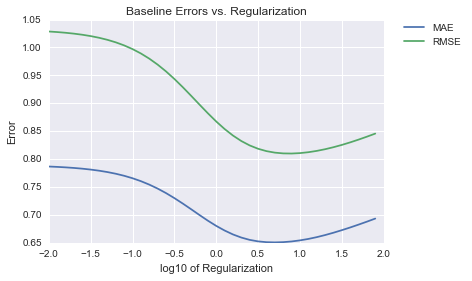

In [84]:
plt.title("Baseline Errors vs. Regularization")
plt.ylabel("Error")
plt.xlabel("log10 of Regularization")
plt.plot(base_powers, base_MAEs, label = "MAE")
plt.plot(base_powers, base_RMSEs, "g", label = "RMSE")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("baseline_reg.jpg")

In [49]:
base_MAE_reg = 10**base_powers[np.argmin(np.array(base_MAEs))]
base_RMSE_reg =10**base_powers[np.argmin(np.array(base_RMSEs))]
base_MAE_reg, base_RMSE_reg

(5.0118723362727504, 7.943282347242862)

In [50]:
base_MAE_best = np.min(np.array(base_MAEs))
base_RMSE_best = np.min(np.array(base_RMSEs))
base_MAE_best, base_RMSE_best

(0.65064744425262966, 0.8099041282837669)

In [51]:
ub = user_based_CF(train_bag)
ub.fit()

Fitting Start!!!

Fitting Progress:0.3333333333333333

Fitting Progress:0.5988023881659765

Fitting Progress:0.6993006916842662

Fitting Progress:0.7999999651472023

Fitting Progress:0.9009008620447413

Fitting Complete!!!



In [68]:
user_MAE = []
user_RMSE = []
user_ks = np.arange(4, 13)
for k in user_ks:
    pred = ub.predict(test_points, 2**k)
    mae, rmse = spt.get_metrics(test_points, pred)
    user_MAE.append(mae)
    user_RMSE.append(rmse)

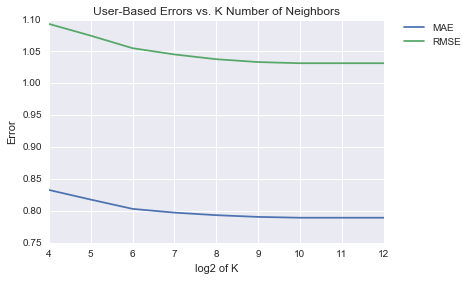

In [69]:
plt.title("User-Based Errors vs. K Number of Neighbors")
plt.ylabel("Error")
plt.xlabel("log2 of K")
plt.plot(user_ks, user_MAE, label = "MAE")
plt.plot(user_ks, user_RMSE, "g", label = "RMSE")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("user_k.jpg")

In [70]:
user_MAE_k = 2**user_ks[np.argmin(np.array(user_MAE))]
user_RMSE_k =2**user_ks[np.argmin(np.array(user_RMSE))]

In [71]:
user_MAE_best = np.min(np.array(user_MAE))
user_RMSE_best = np.min(np.array(user_RMSE))

In [74]:
user_MAE_k, user_RMSE_k

(1024, 1024)

In [73]:
user_MAE_best, user_RMSE_best

(0.78932966968947627, 1.0315944346463402)

In [4]:
ib = item_CF()
ib = ib.fit(train_bag)

In [5]:
item_MAE = []
item_RMSE = []
item_ks = np.arange(11)
for k in item_ks:
    pred = ib.predict(test_points, 2**k)
    mae, rmse = spt.get_metrics(test_points, pred)
    item_MAE.append(mae)
    item_RMSE.append(rmse)

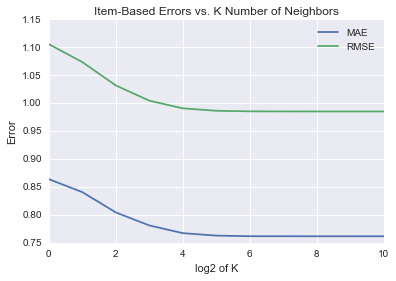

In [83]:
plt.title("Item-Based Errors vs. K Number of Neighbors")
plt.ylabel("Error")
plt.xlabel("log2 of K")
plt.plot(item_ks, item_MAE, label = "MAE")
plt.plot(item_ks, item_RMSE, "g", label = "RMSE")
plt.legend()
plt.savefig("item_k.jpg")

In [7]:
item_MAE_k = 2**item_ks[np.argmin(np.array(item_MAE))]
item_RMSE_k = 2**item_ks[np.argmin(np.array(item_RMSE))]
item_MAE_k, item_RMSE_k

(512, 512)

In [8]:
item_powers = np.arange(-2.0, 2, .1)
item_MAEs = []
item_RMSEs = []
for power in item_powers:
    reg = 10**power
    predictions = ib.predict(test_points, k = item_RMSE_k, reg = reg)
    scores = spt.get_metrics(test_points, predictions)
    item_MAEs.append(scores[0])
    item_RMSEs.append(scores[1])

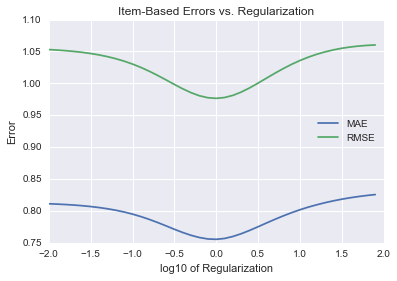

In [82]:
plt.title("Item-Based Errors vs. Regularization")
plt.ylabel("Error")
plt.xlabel("log10 of Regularization")
plt.plot(item_powers, item_MAEs, label = "MAE")
plt.plot(item_powers, item_RMSEs, "g", label = "RMSE")
plt.legend(loc=5)
plt.savefig("item_reg.jpg")

In [10]:
item_MAE_reg = 10**item_powers[np.argmin(np.array(item_MAEs))]
item_RMSE_reg = 10**item_powers[np.argmin(np.array(item_RMSEs))]
item_MAE_reg, item_RMSE_reg

(1.000000000000004, 1.000000000000004)

In [11]:
item_MAE_best = min(item_MAEs)
item_RMSE_best = min(item_RMSEs)
item_MAE_best, item_RMSE_best

(0.75539093090133624, 0.97644507805439473)

In [31]:
als_MAEs = []
als_RMSEs = []
als_ks = np.arange(5, 51, 5)
for k in als_ks:
    mf_als = matrix_factor(k, "als")
    mf_als = mf_als.fit(train_bag, steps = 10)
    predictions = mf_als.predict(test_points)
    scores = spt.get_metrics(test_points, predictions)
    als_MAEs.append(scores[0])
    als_RMSEs.append(scores[1])

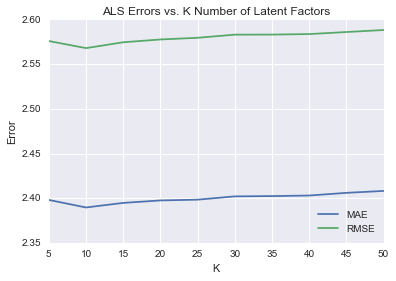

In [32]:
plt.title("ALS Errors vs. K Number of Latent Factors")
plt.ylabel("Error")
plt.xlabel("K")
plt.plot(als_ks, als_MAEs, label = "MAE")
plt.plot(als_ks, als_RMSEs, "g", label = "RMSE")
plt.legend(loc = 0)
plt.savefig("als_k.jpg")

In [33]:
als_MAE_k = als_ks[np.argmin(np.array(als_MAEs))]
als_RMSE_k = als_ks[np.argmin(np.array(als_RMSEs))]
als_MAE_k, als_RMSE_k

(10, 10)

In [36]:
als_MAEs = []
als_RMSEs = []
als_powers = np.arange(-2.0, 2, .1)
for power in als_powers:
    reg  = 10**power
    mf_als = matrix_factor(k = als_RMSE_k, method = "als")
    mf_als = mf_als.fit(train_bag, steps = 10, beta = reg)
    predictions = mf_als.predict(test_points)
    scores = spt.get_metrics(test_points, predictions)
    als_MAEs.append(scores[0])
    als_RMSEs.append(scores[1])

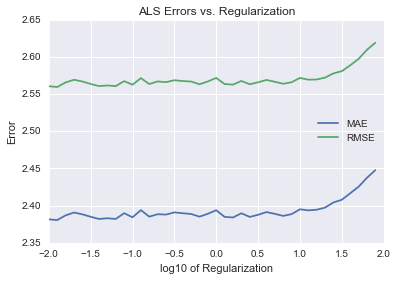

In [81]:
plt.title("ALS Errors vs. Regularization")
plt.ylabel("Error")
plt.xlabel("log10 of Regularization")
plt.plot(als_powers, als_MAEs, label = "MAE")
plt.plot(als_powers, als_RMSEs, "g", label = "RMSE")
plt.legend(loc=5)
plt.savefig("als_reg.jpg")

In [38]:
als_MAE_reg = 10**als_powers[np.argmin(np.array(als_MAEs))]
als_RMSE_reg = 10**als_powers[np.argmin(np.array(als_RMSEs))]
als_MAE_reg, als_RMSE_reg

(0.012589254117941675, 0.012589254117941675)

In [39]:
als_MAE_best = min(als_MAEs)
als_RMSE_best = min(als_RMSEs)
als_MAE_best, als_RMSE_best

(2.3804981253816195, 2.5593352164092154)

In [40]:
sgd_MAEs = []
sgd_RMSEs = []
sgd_ks = np.arange(5, 51, 5)
for k in sgd_ks:
    mf_sgd = matrix_factor(k, "sgd")
    mf_sgd = mf_sgd.fit(train_bag, steps = 10)
    predictions = mf_sgd.predict(test_points)
    scores = spt.get_metrics(test_points, predictions)
    sgd_MAEs.append(scores[0])
    sgd_RMSEs.append(scores[1])

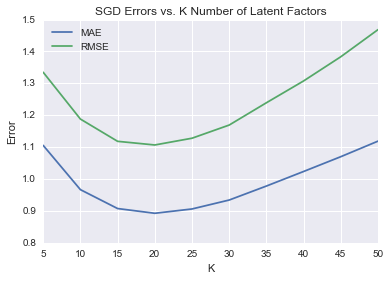

In [41]:
plt.title("SGD Errors vs. K Number of Latent Factors")
plt.ylabel("Error")
plt.xlabel("K")
plt.plot(sgd_ks, sgd_MAEs, label = "MAE")
plt.plot(sgd_ks, sgd_RMSEs, "g", label = "RMSE")
plt.legend(loc = 0)
plt.savefig("sgd_k.jpg")

In [42]:
sgd_MAE_k = sgd_ks[np.argmin(np.array(sgd_MAEs))]
sgd_RMSE_k = sgd_ks[np.argmin(np.array(sgd_RMSEs))]
sgd_MAE_k, sgd_RMSE_k

(20, 20)

In [43]:
sgd_MAEs = []
sgd_RMSEs = []
sgd_powers = np.arange(-2.0, 2, .1)
for power in sgd_powers:
    reg  = 10**power
    mf_sgd = matrix_factor(k = als_RMSE_k, method = "sgd")
    mf_sgd = mf_sgd.fit(train_bag, steps = 10, beta = reg)
    predictions = mf_sgd.predict(test_points)
    scores = spt.get_metrics(test_points, predictions)
    sgd_MAEs.append(scores[0])
    sgd_RMSEs.append(scores[1])

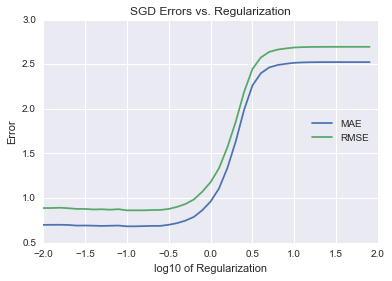

In [85]:
plt.title("SGD Errors vs. Regularization")
plt.ylabel("Error")
plt.xlabel("log10 of Regularization")
plt.plot(sgd_powers, sgd_MAEs, label = "MAE")
plt.plot(sgd_powers, sgd_RMSEs, "g", label = "RMSE")
plt.legend(loc=5)
plt.savefig("sgd_reg.jpg")

In [45]:
sgd_MAE_reg = 10**sgd_powers[np.argmin(np.array(sgd_MAEs))]
sgd_RMSE_reg = 10**sgd_powers[np.argmin(np.array(sgd_RMSEs))]
sgd_MAE_reg, sgd_RMSE_reg

(0.1000000000000002, 0.1000000000000002)

In [46]:
sgd_MAE_best = min(sgd_MAEs)
sgd_RMSE_best = min(sgd_RMSEs)
sgd_MAE_best, sgd_RMSE_best

(0.68395044523097981, 0.86277030457031112)

In [75]:
MAEs = [base_MAE_best, user_MAE_best, item_MAE_best, als_MAE_best, sgd_MAE_best]
RMSEs = [base_RMSE_best, user_RMSE_best, item_RMSE_best, als_RMSE_best, sgd_RMSE_best]
models = ["Baseline", "User Based CF", "Item Based CF",
          "Matrix Factorization ALS", "Matrix Factorization SGD"]

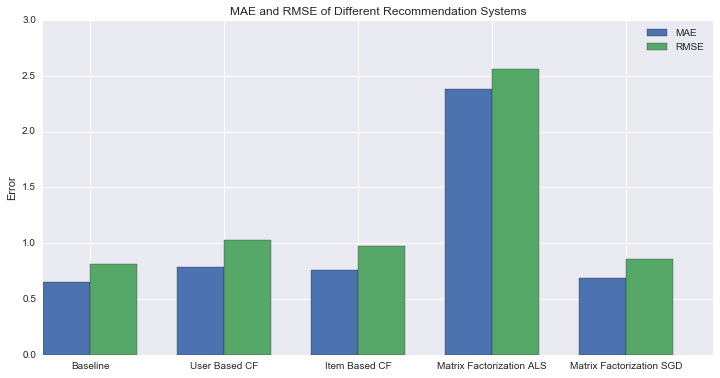

In [80]:
ind = np.arange(5)
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(ind, MAEs, width, color='b')
rects2 = ax.bar(ind + width, RMSEs, width, color='g')

ax.set_ylabel('Error')
ax.set_title('MAE and RMSE of Different Recommendation Systems')
ax.set_xticks(ind + width )
ax.set_xticklabels(models)
ax.legend((rects1[0], rects2[0]), ('MAE', 'RMSE'))
fig.savefig("models.jpg")